# Capstone Project: Word2Vec for Recommendation Systems

> Generating movie recommendations using word2vec

## Project Overview

This project aims to show how [Word2vec](https://en.wikipedia.org/wiki/Word2vec) can be used to build recommendation systems.

A [recommendation system](https://en.wikipedia.org/wiki/Recommender_system) seeks to predict which items a given user would more likelly interact with (click, buy, listen, watch and etc) based on previous interactions made by him or by similar users. This is a big area of interest for research and industry due to its comproved efficacy to increase user engagement and per user revenue. As an example, Netflix estimates that more than 80% of shows people watch on their platform are discovered throught their recommendation systems ([source](https://www.wired.co.uk/article/how-do-netflixs-algorithms-work-machine-learning-helps-to-predict-what-viewers-will-like)).

Word2Vec is a set of technhiques to generate word embeddings for NLP tasks. Its main advantages over other NLP tecnhiques it that it learns the context of words in a sentence based on the surroundings of other words, an illustration of this ability is that the algorithm could understand when the word Buffalo is used to mean the animal buffalo or the city "Buffalo" in the state of New York in a sentence. It does this by representing the words in a multi-dimensional space (embeddings) and these embeddings have the property that the distance between the embeddings is a signal of its similarity.

The dataset used for this project is the [MovieLens](https://grouplens.org/datasets/movielens/), it is probably the most famous and used dataset for recommendation systems. Most libraries for recommendation systems and research articles use this dataset, so this simplifies the benchmarking.


The final project I implemented differed from my original proposal on the following points:

* Dataset

    I initially planed to develop this project against the ["Expedia Hotel Recommendations Kaggle competition"](https://www.kaggle.com/c/expedia-hotel-recommendations/data), however this dataset showed difficult to work due to its size, complexity of features and lack of articles. So after a time spent on EDA, I concluded that using a more common dataset for recommendations systems would be simpler to develop and to benchmark. For this reason, I decided to use the famous [MovieLens](https://grouplens.org/datasets/movielens/) dataset.

    Also, the main benefit in my opinion to use a Kaggle competion for this project was the possibility to easily benchmark my results against the leaderboard. But since my proposal is to demonstrate how a tecnhique of a different domain (NLP), can be used for recommendation systems, I dont expect that my final solution will beat purpose built algorithms.


* Algorithm

    My first idea was to build a custom model in PyTorch to generate the embeddings. However, I ended up using [Gensim](https://radimrehurek.com/gensim/) a common library for word2vec. This approach allowed me to focus more on the technique and in other parts of my project.



## Problem Statement

This problem is defined as: Applying Word2Vec to learn similar movies using the MovieLens dataset.

This dataset is derived from the [MovieLens platform](https://movielens.org/), there users can rate and review movies they have watched, get rich information about movies and receive recommendations of movies to watch next.

In this project I used the smaller version of the dataset called MovieLens100K which contains 100000 of ratings of 9000 movies, made by 600 users ([link for dataset](https://grouplens.org/datasets/movielens/latest/)).

The goal here is to demonstrate how a tecnhique of NLP can be abbused to generate recommendations, I explore ways to serve the recommendations based on embeddings in a scalable way and I also create a sample application to visualize the generated recommendations.

I dont intend to produce state of the art results, but simply demonstrate a good enough and simple tecnhique to generate recommendations.

## Metrics

The main metric I used to evaluate my model was "Average Precision at k" ([source](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision)). This is a common metric used by recommendation systems and also simple to calculate.

Since the recommendation system I built suggests similar items (item-to-item) and the MovieLens dataset doesn't have a groundtruth dataset for item similarity, I calculated the metric using the following approach: 

1. Isolated X% of my users to use for evaluation
1. For each user U I selected all his positive movie ratings MR
1. For each MR I calculated 5 suggestions for the movie rated
1. I checked if the suggested movies were inside the MR, if so, I considered it as a match. I calculated the precision P for each recommendation.
1. I sumed all P and divided by the number of users to have my final average precision at 5.

The source code for the way I calculated this metric can be found [here](TODO).

## Data Exploration

The data exploration I performed for this project can be found on the notebook "010"

## Appendix - References

* https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/

In [ ]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
movies_df = pd.read_csv("data/ml-latest-small/movies.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies_df.shape

(9742, 3)

In [ ]:
ratings_df = pd.read_csv("data/ml-latest-small/ratings.csv")
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
ratings_df.shape

(100836, 4)

Checking ammout of users

In [ ]:
ratings_df["userId"].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

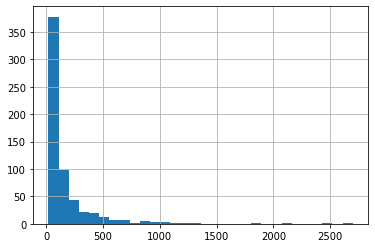

In [ ]:
ratings_df["userId"].value_counts().hist(bins=30)

In [ ]:
ratings_df["movieId"].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
5986        1
100304      1
34800       1
83976       1
8196        1
Name: movieId, Length: 9724, dtype: int64

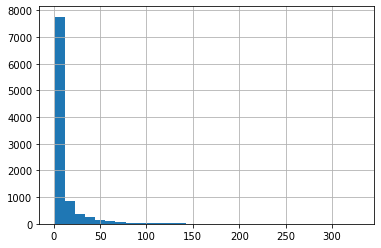

In [ ]:
ratings_df["movieId"].value_counts().hist(bins=30)

We can observe that most few users and movies concentrate most reviews. This is a common long tail problem and very common with recommendation systems (can promote already popular items)

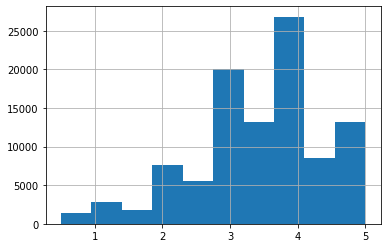

In [ ]:
ratings_df["rating"].hist()